# Mecanismo de Recomendação de séries
## Objetivo
O objetivo do modelo será recomendar séries ao usuário que estejam de acordo com os gostos dele, e a base para isso serão as avaliações feitas pelos usuários, além dos gêneros das séries avaliadas. Para que isso fosse feito, vimos que temos que responder as perguntas a seguir:
* Como "posicionar" um usuário próximo a outros usuários que consomem (e avaliam positivamente) o mesmo conteúdo?
* Quais dados dos usuários serão o critério para esse posicionamento?
* Uma vez posicionado, como será feita a escolha dos títulos a serem recomendados?

In [27]:
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA

In [28]:
reviews_tv_shows_df = pd.read_csv('./reviews_tv_shows.csv')
reviews_tv_shows_df

,Unnamed: 0,tv_show,16,18,35,37,80,878,9648,10751,...,10762,10763,10764,10765,10766,10767,10768,user,rating,id_y
0,0,Invincible,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,ChrisSawin,10.00000,6058917c5c071b00546ccab3
1,1,The Flash,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,Tanasia,7.61794,5f98b89877e1f600358ada9f
2,2,The Flash,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,BruhDev,7.61794,605e5e40d2f5b500286aa8ed
3,3,The Good Doctor,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,drtvnut89,10.00000,5a0a07c192514131210073ec
4,4,The Handmaid's Tale,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,Rangan,7.61794,59bd8f6b92514135510185ab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,371,The Outsider,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,Kewl_Kat,5.00000,5e66a0a68d52c9001d3f9200
372,372,The Ren & Stimpy Show,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,Star Lord,8.00000,58c104909251417327004598
373,373,The Ren & Stimpy Show,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,danny700,7.61794,590a8b6b9251414fbe009e72
374,374,NYPD Blue,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Bazzjazz,10.00000,5acfe928c3a36842ca00354c


## Transformação do Dataset
Atualmente temos um dataset em que cada linha representa uma avaliação feita por algum usuário. Como o elemento central do nosso modelo são os usuários, precisamos transformar esse dataset para que cada linha represente um usuário, criando novas colunas para cada série e então colocando como valor dessas colunas as notas dadas nas avalições.

In [29]:
users_df = pd.pivot_table(reviews_tv_shows_df, values='rating', index='user', columns='tv_show')
users_df

tv_show,13 Reasons Why,3Below: Tales of Arcadia,A Discovery of Witches,A Million Little Things,AIBOU: Tokyo Detective Duo,Absentia,Agries Melisses,Akame ga Kill!,Alexa & Katie,All American,...,Westworld,What We Do in the Shadows,White Collar,Wizards: Tales of Arcadia,Wynonna Earp,Xena: Warrior Princess,YOU,Your Lie in April,iCarly,iZombie
user,,,,,,,,,,,,,,,,,,,,,
AKJETJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AdamRife,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aditya@13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ahstaroth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tmdbsom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN
tomk1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wan_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
users_df = users_df.fillna(users_df.mean(axis=0))
users_df

tv_show,13 Reasons Why,3Below: Tales of Arcadia,A Discovery of Witches,A Million Little Things,AIBOU: Tokyo Detective Duo,Absentia,Agries Melisses,Akame ga Kill!,Alexa & Katie,All American,...,Westworld,What We Do in the Shadows,White Collar,Wizards: Tales of Arcadia,Wynonna Earp,Xena: Warrior Princess,YOU,Your Lie in April,iCarly,iZombie
user,,,,,,,,,,,,,,,,,,,,,
AKJETJ,6.80897,8.0,8.0,7.0,8.0,4.0,2.0,4.0,8.0,10.0,...,6.047176,7.61794,10.0,6.0,7.61794,7.61794,6.923588,10.0,10.0,7.61794
Abro,6.80897,8.0,8.0,7.0,8.0,4.0,2.0,4.0,8.0,10.0,...,6.047176,7.61794,10.0,6.0,7.61794,7.61794,6.923588,10.0,10.0,7.61794
AdamRife,6.80897,8.0,8.0,7.0,8.0,4.0,2.0,4.0,8.0,10.0,...,6.047176,7.61794,10.0,6.0,7.61794,7.61794,6.923588,10.0,10.0,7.61794
Aditya@13,6.80897,8.0,8.0,7.0,8.0,4.0,2.0,4.0,8.0,10.0,...,6.047176,7.61794,10.0,6.0,7.61794,7.61794,6.923588,10.0,10.0,7.61794
Ahstaroth,6.80897,8.0,8.0,7.0,8.0,4.0,2.0,4.0,8.0,10.0,...,6.047176,7.61794,10.0,6.0,7.61794,7.61794,6.923588,10.0,10.0,7.61794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tmdbsom,6.80897,8.0,8.0,7.0,8.0,4.0,2.0,4.0,8.0,10.0,...,6.047176,7.61794,10.0,6.0,7.61794,7.61794,6.923588,10.0,10.0,7.61794
tomk1,6.80897,8.0,8.0,7.0,8.0,4.0,2.0,4.0,8.0,10.0,...,6.047176,7.61794,10.0,6.0,7.61794,7.61794,6.923588,10.0,10.0,7.61794
wan_,6.80897,8.0,8.0,7.0,8.0,4.0,2.0,4.0,8.0,10.0,...,6.047176,7.61794,10.0,6.0,7.61794,7.61794,6.923588,10.0,10.0,7.61794


## O Modelo
A Técnica de Machine Learning a ser utilizada será clusterização, essa foi a forma escolhida para agrupar os usuários baseado nas diferenças nas avaliações. Para essa PoC, utilizaremos o KMeans por ter sido o caminho que vimos em sala de aula com mais extensão, e ser suficiente para esse modelo inicial.

No código a seguir faremos a escolha do número de clusters ótimo para o modelo, em seguida criaremos o modelo a faremos a clusterização. 

--------------------

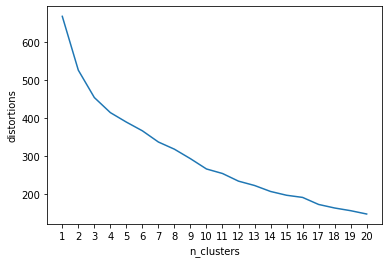

In [31]:
distortions = []
n_clusters =  range(1,21)


for n in n_clusters:
    print("-", end = '')
    kmeans_model = KMeans(n_clusters=n, random_state=0)
    kmeans_model.fit(users_df)
    distortions.append(kmeans_model.inertia_)
    
elbow_plot_df = pd.DataFrame({'n_clusters': n_clusters, 'distortions': distortions})
sns.lineplot(x='n_clusters', y='distortions', data = elbow_plot_df)
plt.xticks(n_clusters)
plt.show()

In [39]:
kmeans_model = KMeans(n_clusters=7, random_state=0).fit(users_df)
clustering_pred = kmeans_model.predict(users_df)

unique_counts = collections.Counter(e for e in clustering_pred)
unique_counts

Counter({0: 174, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 4})

<BarContainer object of 7 artists>

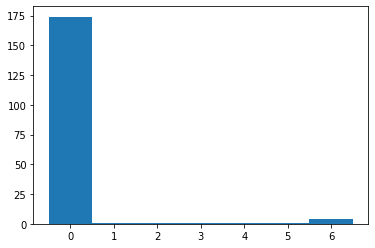

In [40]:
plt.bar(unique_counts.keys(), unique_counts.values(), 1)


In [41]:
x = users_df.values
pca = PCA(n_components= 2, random_state=0)
pca.fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PCA1','PCA2'])
principalDf

,PCA1,PCA2
0,-1.008230e-15,-5.510126e-16
1,-6.869176e-02,2.582767e-02
2,-5.073477e-04,-3.621516e-03
3,-2.886260e-15,0.000000e+00
4,-7.215651e-16,1.037603e-15
...,...,...
178,-9.846008e-16,-5.984143e-16
179,-6.315802e-16,-5.240729e-16
180,-9.845920e-16,-6.002404e-16
181,-6.315802e-16,-5.240729e-16


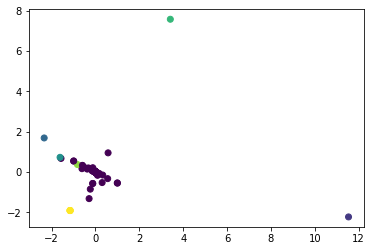

In [42]:
plt.scatter(principalDf['PCA1'], principalDf['PCA2'], c=clustering_pred)
